# Chapter 3. Modeling with Linear Regressions

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [2]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# from theano import shared
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import arviz as az

In [3]:
# az.style.use('arviz-darkgrid')

## Simple linear regression

In [4]:
N = 100
alpha_real = 2.5
beta_real = 0.9

eps_real = dist.Normal(loc=0, scale=1).sample(random.PRNGKey(0), (N,))

x = dist.Normal(loc=10, scale=1.).sample(random.PRNGKey(1), (N,)) # Same seed produces perfect line
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
# x = x - x.mean()
# or standardize the data
# x = (x - x.mean())/x.std()
# y = (y - y.mean())/y.std()

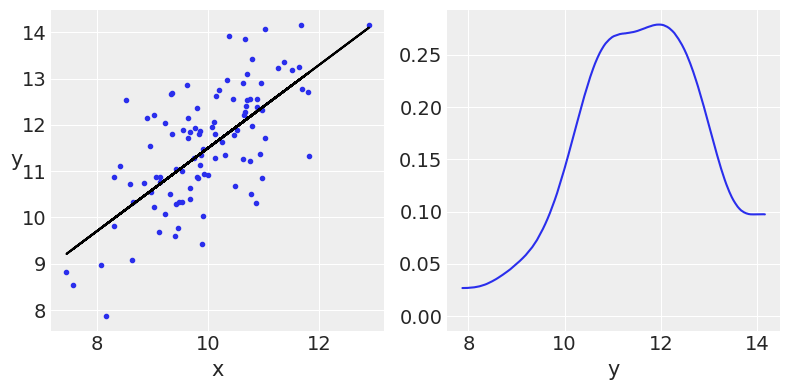

In [5]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')

az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [6]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = numpyro.deterministic('μ', α + β * x)
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs, sample_shape=(len(y),))
        
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)
mcmc.run(random.PRNGKey(seed), obs=y)

sample: 100%|██████████████████████████████████████████| 3000/3000 [00:00<00:00, 3828.37it/s, 11 steps of size 6.59e-02. acc. prob=0.94]


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

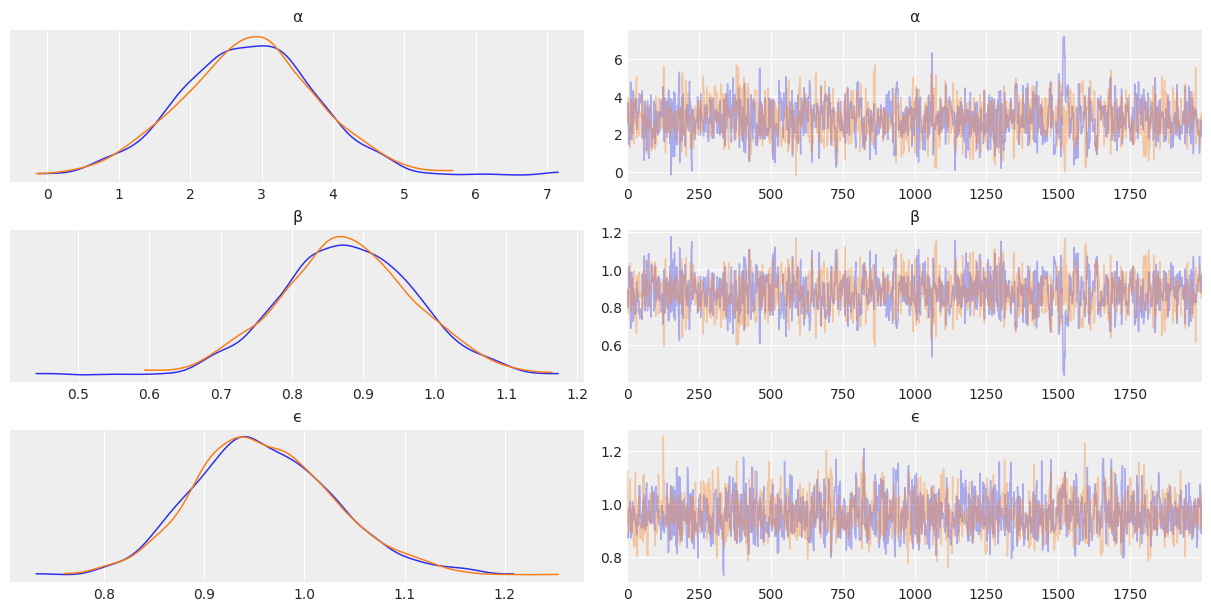

In [7]:
az.plot_trace(mcmc, var_names=['α', 'β', 'ϵ'], compact=False)

### Modyfing the data before running the models

<AxesSubplot:xlabel='α', ylabel='β'>

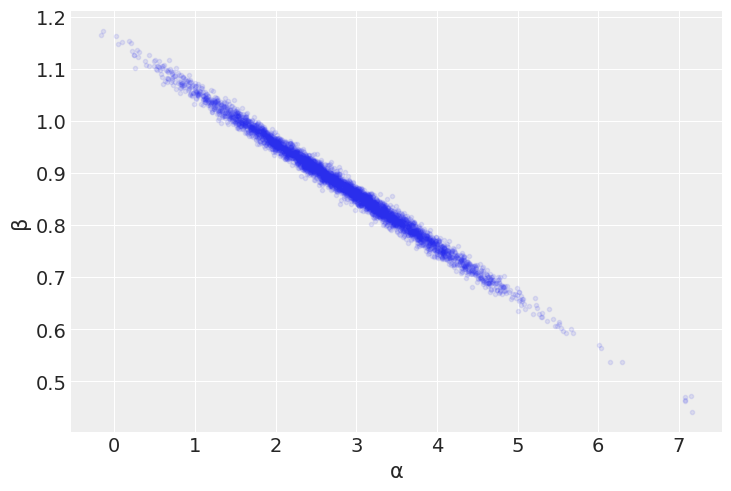

In [8]:
az.plot_pair(mcmc, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.1})  # UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs

### interpreting the posterior

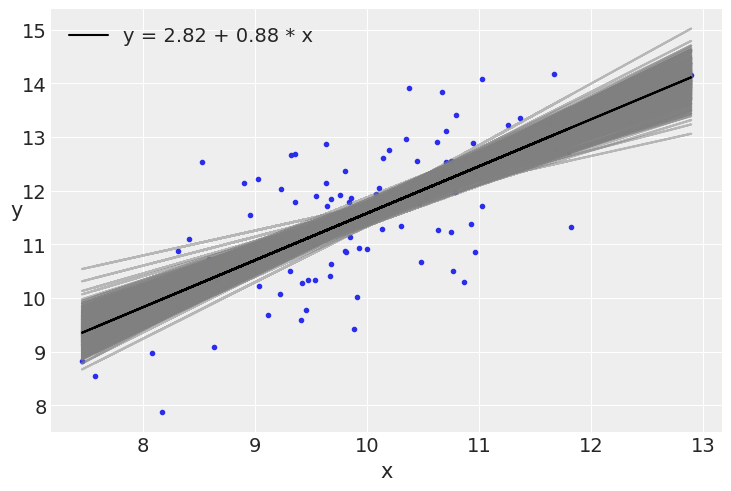

In [9]:
plt.plot(x, y, 'C0.')

alpha_m = mcmc.get_samples()['α'].mean()
beta_m = mcmc.get_samples()['β'].mean()

draws = range(0, len(mcmc.get_samples()['α']), 10)
plt.plot(x, mcmc.get_samples()['α'][jnp.array(draws)] + mcmc.get_samples()['β'][jnp.array(draws)]  # https://github.com/google/jax/issues/4564
         * x[:, jnp.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

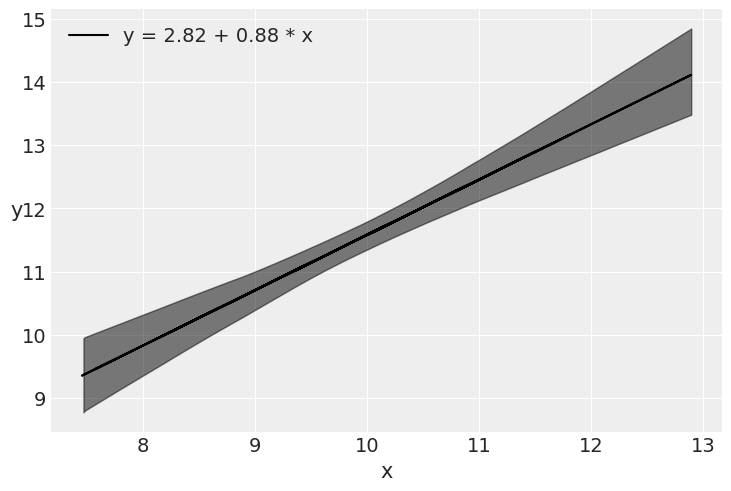

In [10]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, mcmc.get_samples()['μ'], hdi_prob=0.98, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

In [11]:
pred = Predictive(model=mcmc.sampler.model, posterior_samples=mcmc.get_samples(), return_sites=['y_pred'])
ppc = pred(random.PRNGKey(seed))

In [12]:
ppc['y_pred'].shape

(4000, 100, 100)

In [13]:
ppc['y_pred'] = ppc['y_pred'][:100]
ppc['y_pred'].shape

(100, 100, 100)

<AxesSubplot:xlabel='y_pred'>

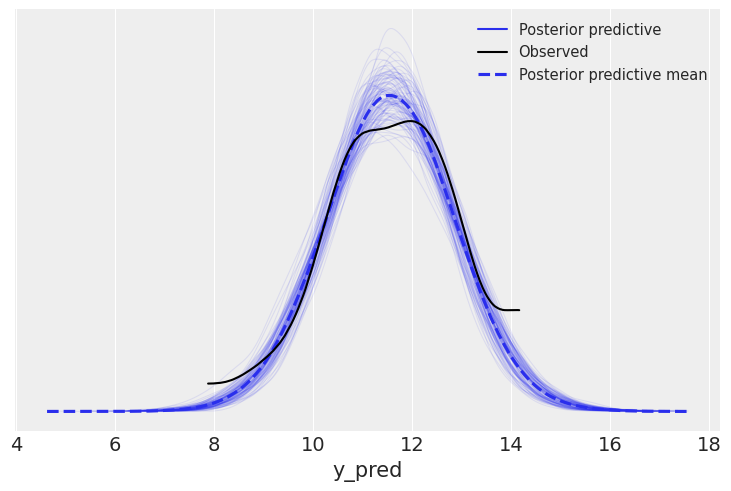

In [14]:
samples = az.from_numpyro(mcmc, posterior_predictive=ppc)
az.plot_ppc(samples, mean=True, observed=True, alpha=0.1)

Text(0, 0.5, 'y')

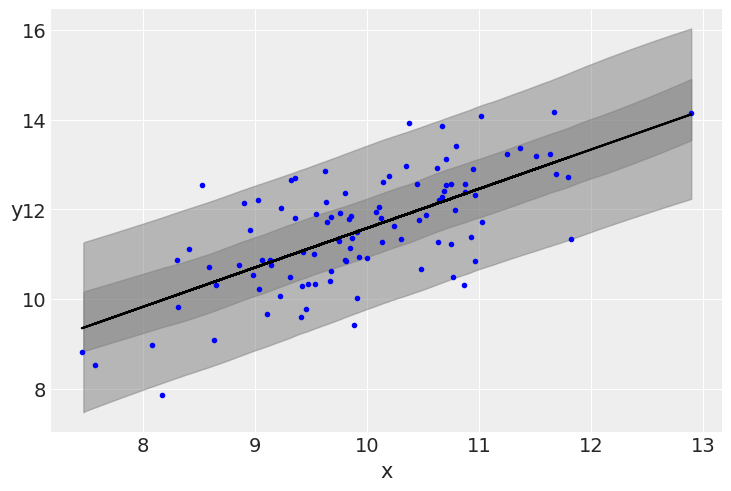

In [15]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [16]:
az.r2_score(y, ppc['y_pred'])

r2        0.44905096
r2_std    0.03545001
dtype: object

### The multivariate normal distribution 
Actually the bivariate

Text(-0.05, 0.5, 'x_2')

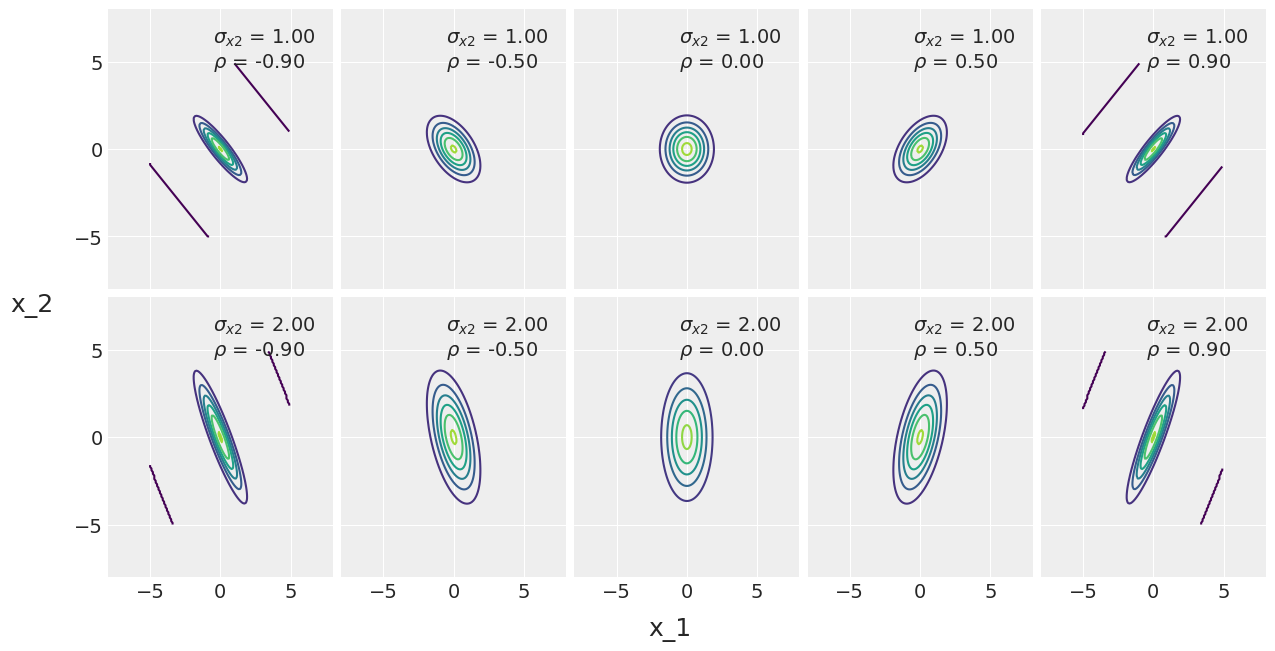

In [17]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = jnp.mgrid[-5:5:.1, -5:5:.1]
pos = jnp.empty(k.shape + (2,))
# pos[:, :, 0] = k
# pos[:, :, 1] = l
pos = pos.at[:, :, 0].set(k)
pos = pos.at[:, :, 1].set(l)


f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        
        rv = dist.MultivariateNormal(jnp.array([0,0]), covariance_matrix=cov)

        ax[i, j].contour(k, l, jnp.exp(rv.log_prob(pos)), levels=6)
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0, label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

In [18]:
data = jnp.stack((x, y)).T

def model(obs=None):
    
    μ = numpyro.sample('μ', dist.Normal(loc=data.mean(0), scale=10))
    
    σ_1 = numpyro.sample('σ_1', dist.HalfNormal(scale=10))
    σ_2 = numpyro.sample('σ_2', dist.HalfNormal(scale=10))
    ρ = numpyro.sample('ρ', dist.Uniform(low=-1., high=1.))
    
    r2 = numpyro.deterministic('r2', ρ**2)
    
    cov = jnp.stack((jnp.array([σ_1**2, σ_1*σ_2*ρ]),
                    jnp.array([σ_1*σ_2*ρ, σ_2**2])))
    
    y_pred = numpyro.sample('y_pred', dist.MultivariateNormal(loc=μ, covariance_matrix=cov), obs=obs)
    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc2.run(random.PRNGKey(seed), obs=data)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 4882.91it/s, 3 steps of size 6.17e-01. acc. prob=0.86]


array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

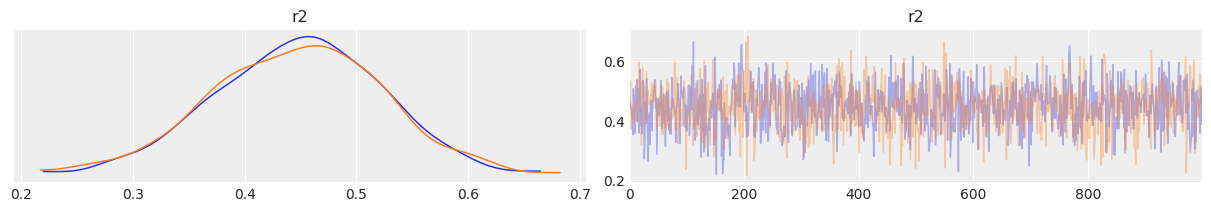

In [19]:
az.plot_trace(mcmc2, var_names=['r2'], compact=False)

In [20]:
az.summary(mcmc2, var_names=['r2'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
r2  0.447  0.075   0.314    0.596      0.002    0.001    1432.0    1332.0   

    r_hat  
r2    1.0

## Robust linear regression

In [21]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

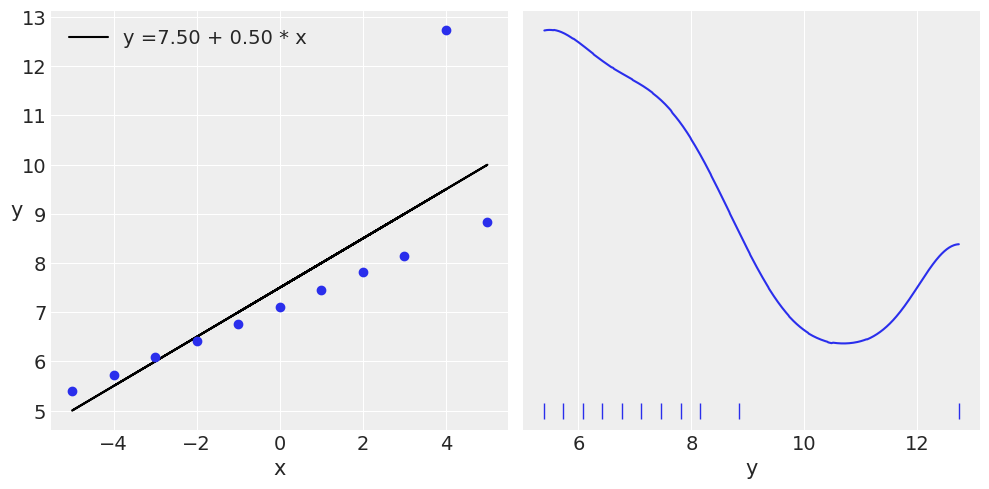

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = jnp.polyfit(x_3, y_3, deg=1) # equivulant to stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [23]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=y_3.mean(), scale=1))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfNormal(scale=5))
    ν_ = numpyro.sample('ν_', dist.Exponential(rate=1/29))
    ν = numpyro.deterministic('ν', ν_ + 1)

    y_pred = numpyro.sample('y_pred', dist.StudentT(df=ν, loc=α + β * x_3, scale=ϵ), obs=obs)
    
kernel = NUTS(model)
mcmc3 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc3.run(random.PRNGKey(seed), obs=y_3)

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 4882.93it/s, 15 steps of size 1.06e-01. acc. prob=0.81]


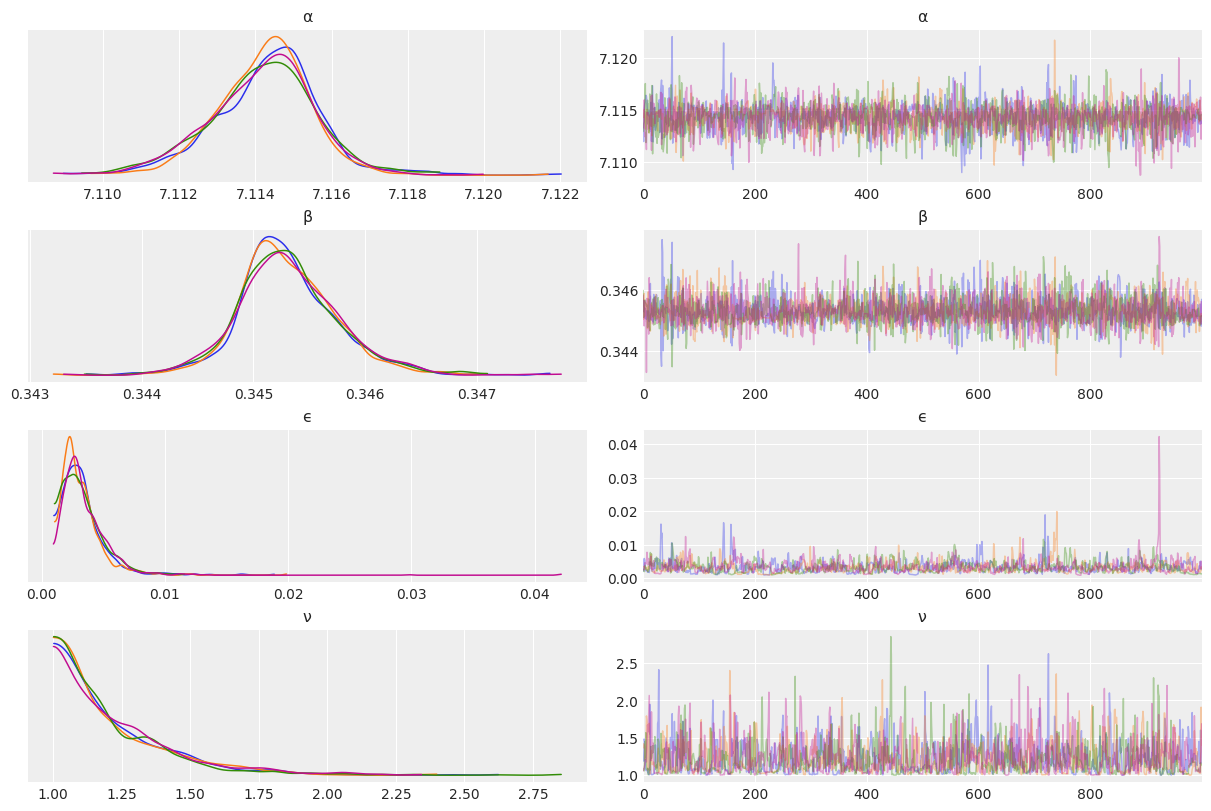

In [24]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(mcmc3, var_names=varnames, compact=False);

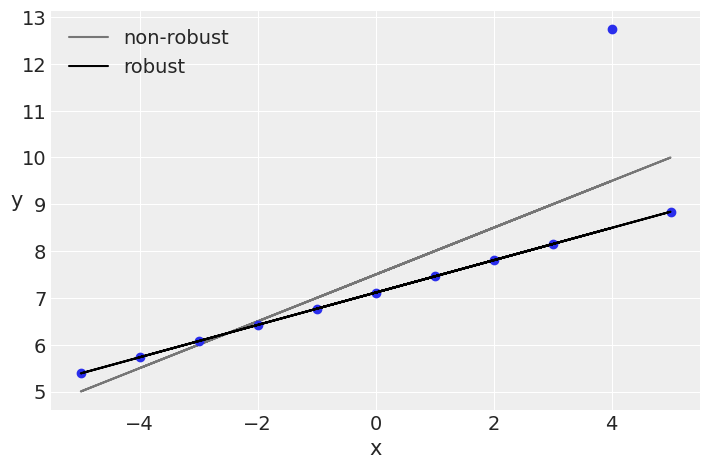

In [25]:
beta_c, alpha_c = jnp.polyfit(x_3, y_3, deg=1) 

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = jnp.mean(mcmc3.get_samples()['α'])
beta_m = jnp.mean(mcmc3.get_samples()['β'])
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

In [26]:
az.summary(mcmc3, var_names=varnames)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α  7.114  0.001   7.112    7.117      0.000    0.000    3155.0    2179.0   
β  0.345  0.000   0.345    0.346      0.000    0.000    3861.0    2209.0   
ϵ  0.003  0.002   0.001    0.006      0.000    0.000     402.0     327.0   
ν  1.219  0.214   1.000    1.604      0.006    0.004     906.0     847.0   

   r_hat  
α   1.00  
β   1.00  
ϵ   1.01  
ν   1.00

In [27]:
pred = Predictive(model=mcmc3.sampler.model, posterior_samples=mcmc3.get_samples(), return_sites=['y_pred'])
ppc = pred(random.PRNGKey(seed))

In [28]:
ppc['y_pred'] = ppc['y_pred'][:200]
ppc['y_pred'].shape

(200, 11)

(0.0, 12.0)

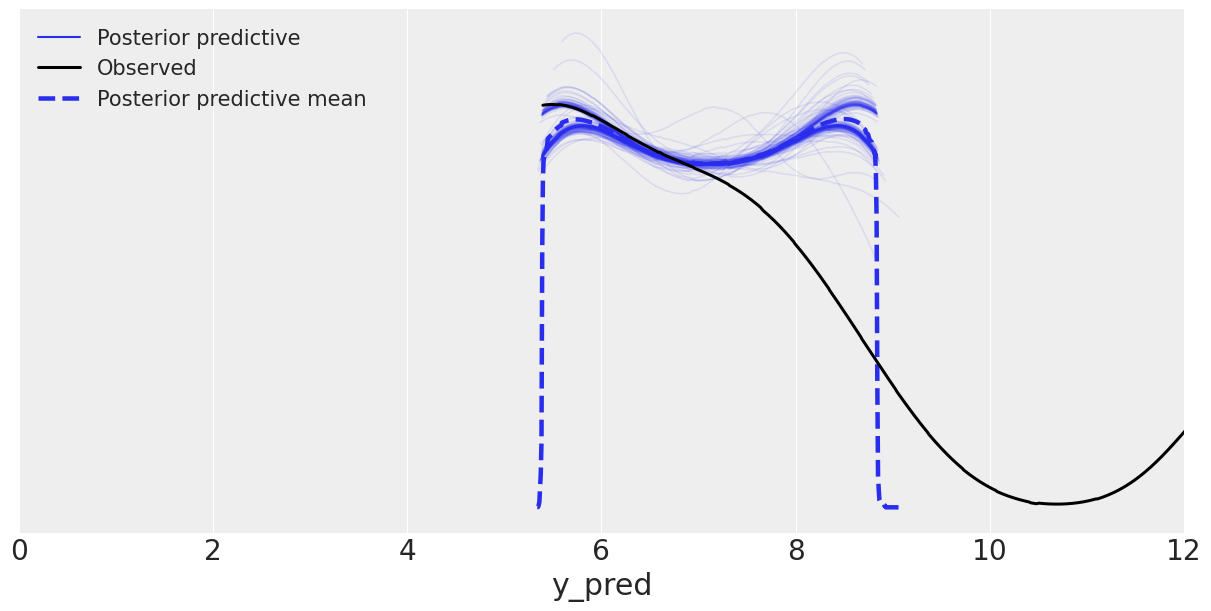

In [29]:
data_ppc = az.from_numpyro(mcmc3, posterior_predictive=ppc)
az.plot_ppc(data_ppc, figsize=(12, 6), mean=True, alpha=0.1, color='C0')
plt.xlim(0, 12)

## Hierarchical linear regression

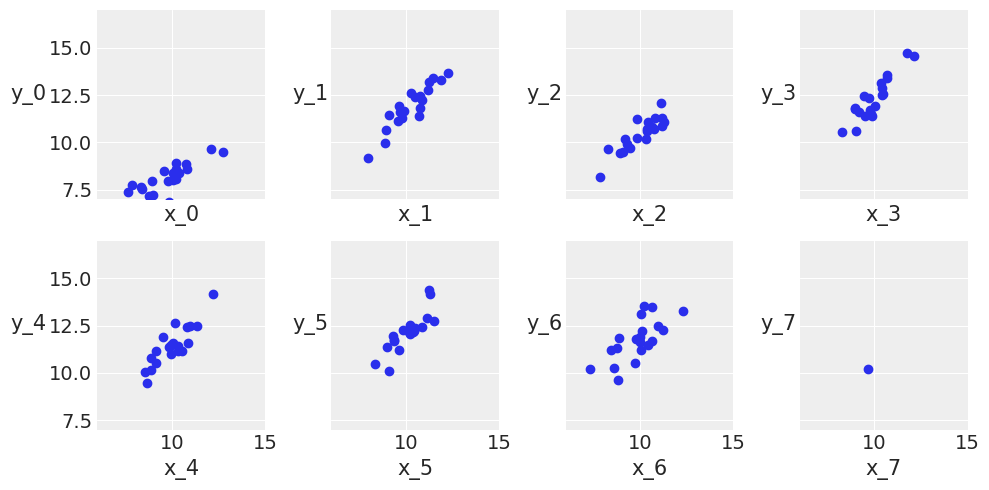

In [30]:
N = 20
M = 8
idx = jnp.repeat(jnp.arange(M-1), N)
idx = jnp.append(idx, 7)

# alpha_real = numpyro.sample('alpha_real', dist.Normal(loc=2.5, scale=0.5), sample_shape=(M,)) 
alpha_real = dist.Normal(loc=2.5, scale=0.5).sample(random.PRNGKey(seed), (M,))
beta_real = dist.Beta(concentration1=6, concentration0=1).sample(random.PRNGKey(seed), (M,))
eps_real = dist.Normal(loc=0, scale=0.5).sample(random.PRNGKey(seed+1), (len(idx),))
                                                
y_m = jnp.zeros(len(idx))
x_m = dist.Normal(loc=10, scale=1.).sample(random.PRNGKey(seed), (len(idx),))
                                           
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = list(ax.flat) # np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [31]:
x_centered = x_m - x_m.mean()

In [32]:
def model(obs=None):
    with numpyro.handlers.seed(rng_seed=seed):
        α_tmp = numpyro.sample("α_tmp", dist.Normal(loc=0, scale=10).expand([M]))
        β = numpyro.sample("β", dist.Normal(loc=0, scale=10).expand([M]))
    
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    ν = numpyro.sample('ν', dist.Exponential(rate=1/30))
    
    y_pred = numpyro.sample('y_pred', dist.StudentT(df=ν, loc=α_tmp[idx] + β[idx] * x_centered, scale=ϵ), obs=obs)
    
    α = numpyro.deterministic('α', α_tmp - β * x_m.mean())
    
kernel = NUTS(model)
mcmc4 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc4.run(random.PRNGKey(seed), obs=y_m)

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 3526.99it/s, 63 steps of size 8.52e-02. acc. prob=0.96]


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

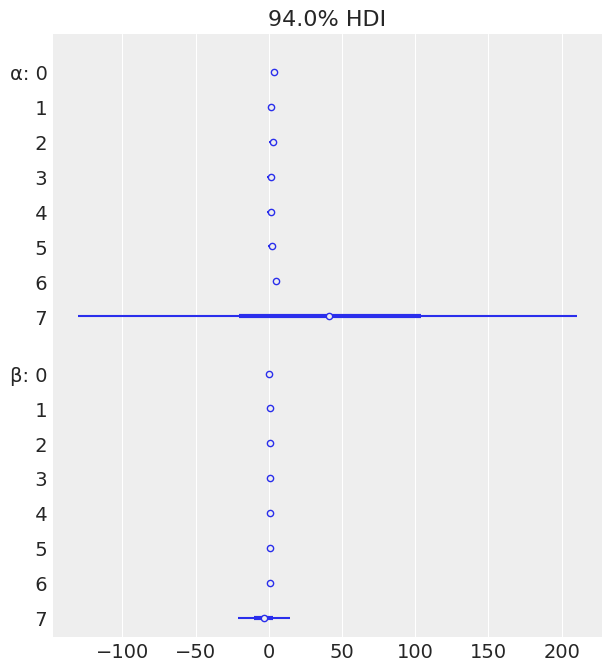

In [33]:
az.plot_forest(mcmc4, var_names=['α', 'β'], combined=True)

<img src='./imgs/B11197_03_15.png' width="700">

In [34]:
def model(obs=None):
    # Hyper-priors
    α_μ_tmp = numpyro.sample('α_μ_tmp', dist.Normal(loc=0, scale=10))
    α_σ_tmp = numpyro.sample('α_σ_tmp', dist.HalfNormal(scale=10))
    β_μ = numpyro.sample('β_μ', dist.Normal(loc=0, scale=10))
    β_σ = numpyro.sample('β_σ', dist.HalfNormal(scale=10))
    
    # Priors
    with numpyro.handlers.seed(rng_seed=seed):
        α_tmp = numpyro.sample("α_tmp", dist.Normal(loc=α_μ_tmp, scale=α_σ_tmp).expand([M]))
        β = numpyro.sample("β", dist.Normal(loc=β_μ, scale=β_σ).expand([M]))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    ν = numpyro.sample('ν', dist.Exponential(rate=1/30))
    
    y_pred = numpyro.sample('y_pred', dist.StudentT(df=ν, loc=α_tmp[idx] + β[idx] * x_centered, scale=ϵ), obs=obs)
    
    α = numpyro.deterministic('α', α_tmp - β * x_m.mean())
    α_μ = numpyro.deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = numpyro.deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())
    
kernel = NUTS(model)
mcmc5 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc5.run(random.PRNGKey(seed), obs=y_m)

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 3715.94it/s, 15 steps of size 4.17e-01. acc. prob=0.83]


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

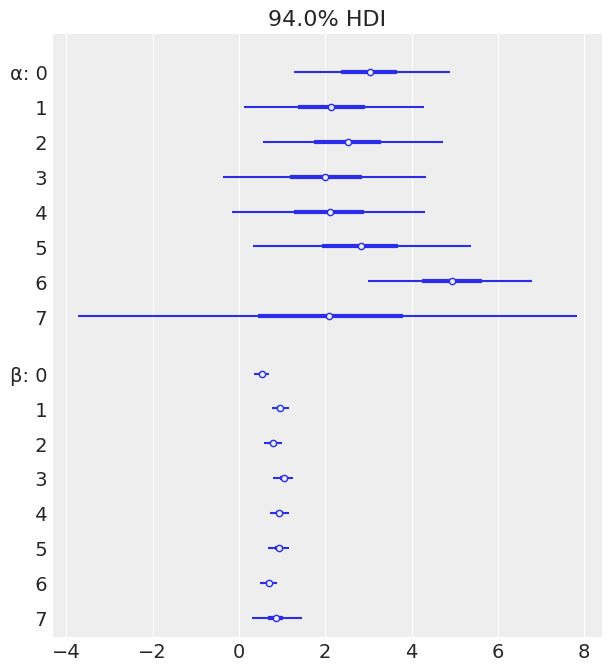

In [35]:
az.plot_forest(mcmc5, var_names=['α', 'β'], combined=True)

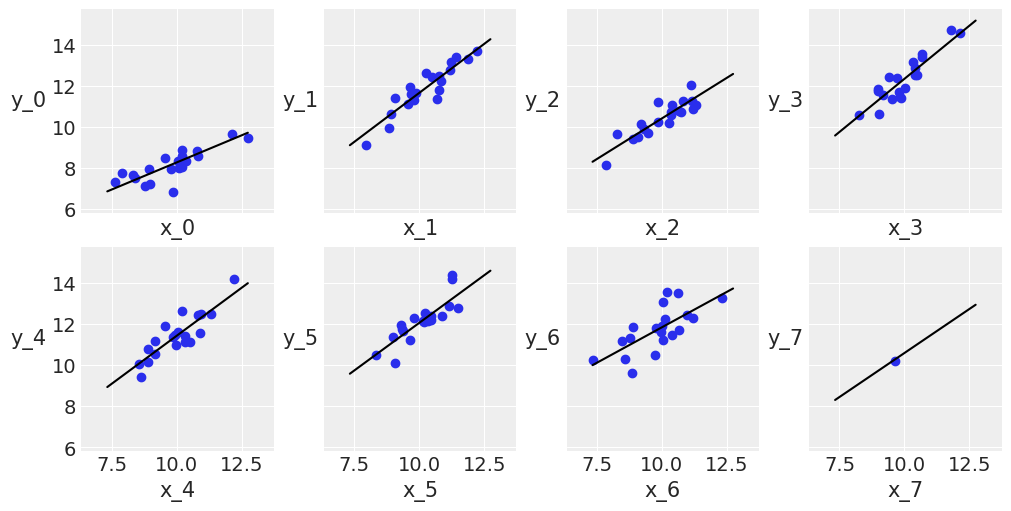

In [36]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True)
ax = list(ax.flat) # np.ravel(ax)

j, k = 0, N
x_range = jnp.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):

    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    
    alpha_m = mcmc5.get_samples()['α'][:, i].mean()
    beta_m = mcmc5.get_samples()['β'][:, i].mean()
    
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k', label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    
    j += N
    k += N

## Polynomial regression

Text(0, 0.5, 'y')

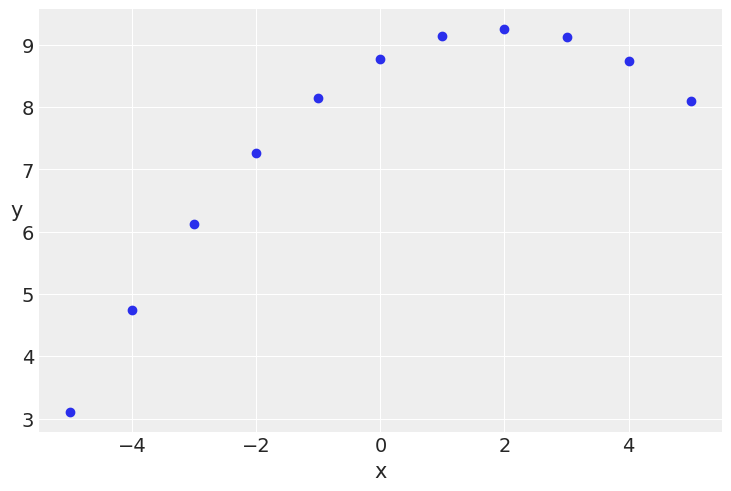

In [37]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [38]:
def model(obs=None):
    
    α = numpyro.sample("α", dist.Normal(loc=y_2.mean(), scale=1))
    β1 = numpyro.sample("β1", dist.Normal(loc=0, scale=1))
    β2 = numpyro.sample("β2", dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
                        
    mu = numpyro.deterministic('mu', α + β1 * x_2 + β2 * x_2**2)
                            
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=mu, scale=ϵ), obs=obs)
    

kernel = NUTS(model)
mcmc6 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc6.run(random.PRNGKey(seed), obs=y_2)

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 4296.65it/s, 35 steps of size 1.52e-02. acc. prob=0.88]


array([[<AxesSubplot:title={'center':'mu\n0'}>,
        <AxesSubplot:title={'center':'mu\n0'}>],
       [<AxesSubplot:title={'center':'mu\n1'}>,
        <AxesSubplot:title={'center':'mu\n1'}>],
       [<AxesSubplot:title={'center':'mu\n2'}>,
        <AxesSubplot:title={'center':'mu\n2'}>],
       [<AxesSubplot:title={'center':'mu\n3'}>,
        <AxesSubplot:title={'center':'mu\n3'}>],
       [<AxesSubplot:title={'center':'mu\n4'}>,
        <AxesSubplot:title={'center':'mu\n4'}>],
       [<AxesSubplot:title={'center':'mu\n5'}>,
        <AxesSubplot:title={'center':'mu\n5'}>],
       [<AxesSubplot:title={'center':'mu\n6'}>,
        <AxesSubplot:title={'center':'mu\n6'}>],
       [<AxesSubplot:title={'center':'mu\n7'}>,
        <AxesSubplot:title={'center':'mu\n7'}>],
       [<AxesSubplot:title={'center':'mu\n8'}>,
        <AxesSubplot:title={'center':'mu\n8'}>],
       [<AxesSubplot:title={'center':'mu\n9'}>,
        <AxesSubplot:title={'center':'mu\n9'}>],
       [<AxesSubplot:title={'c

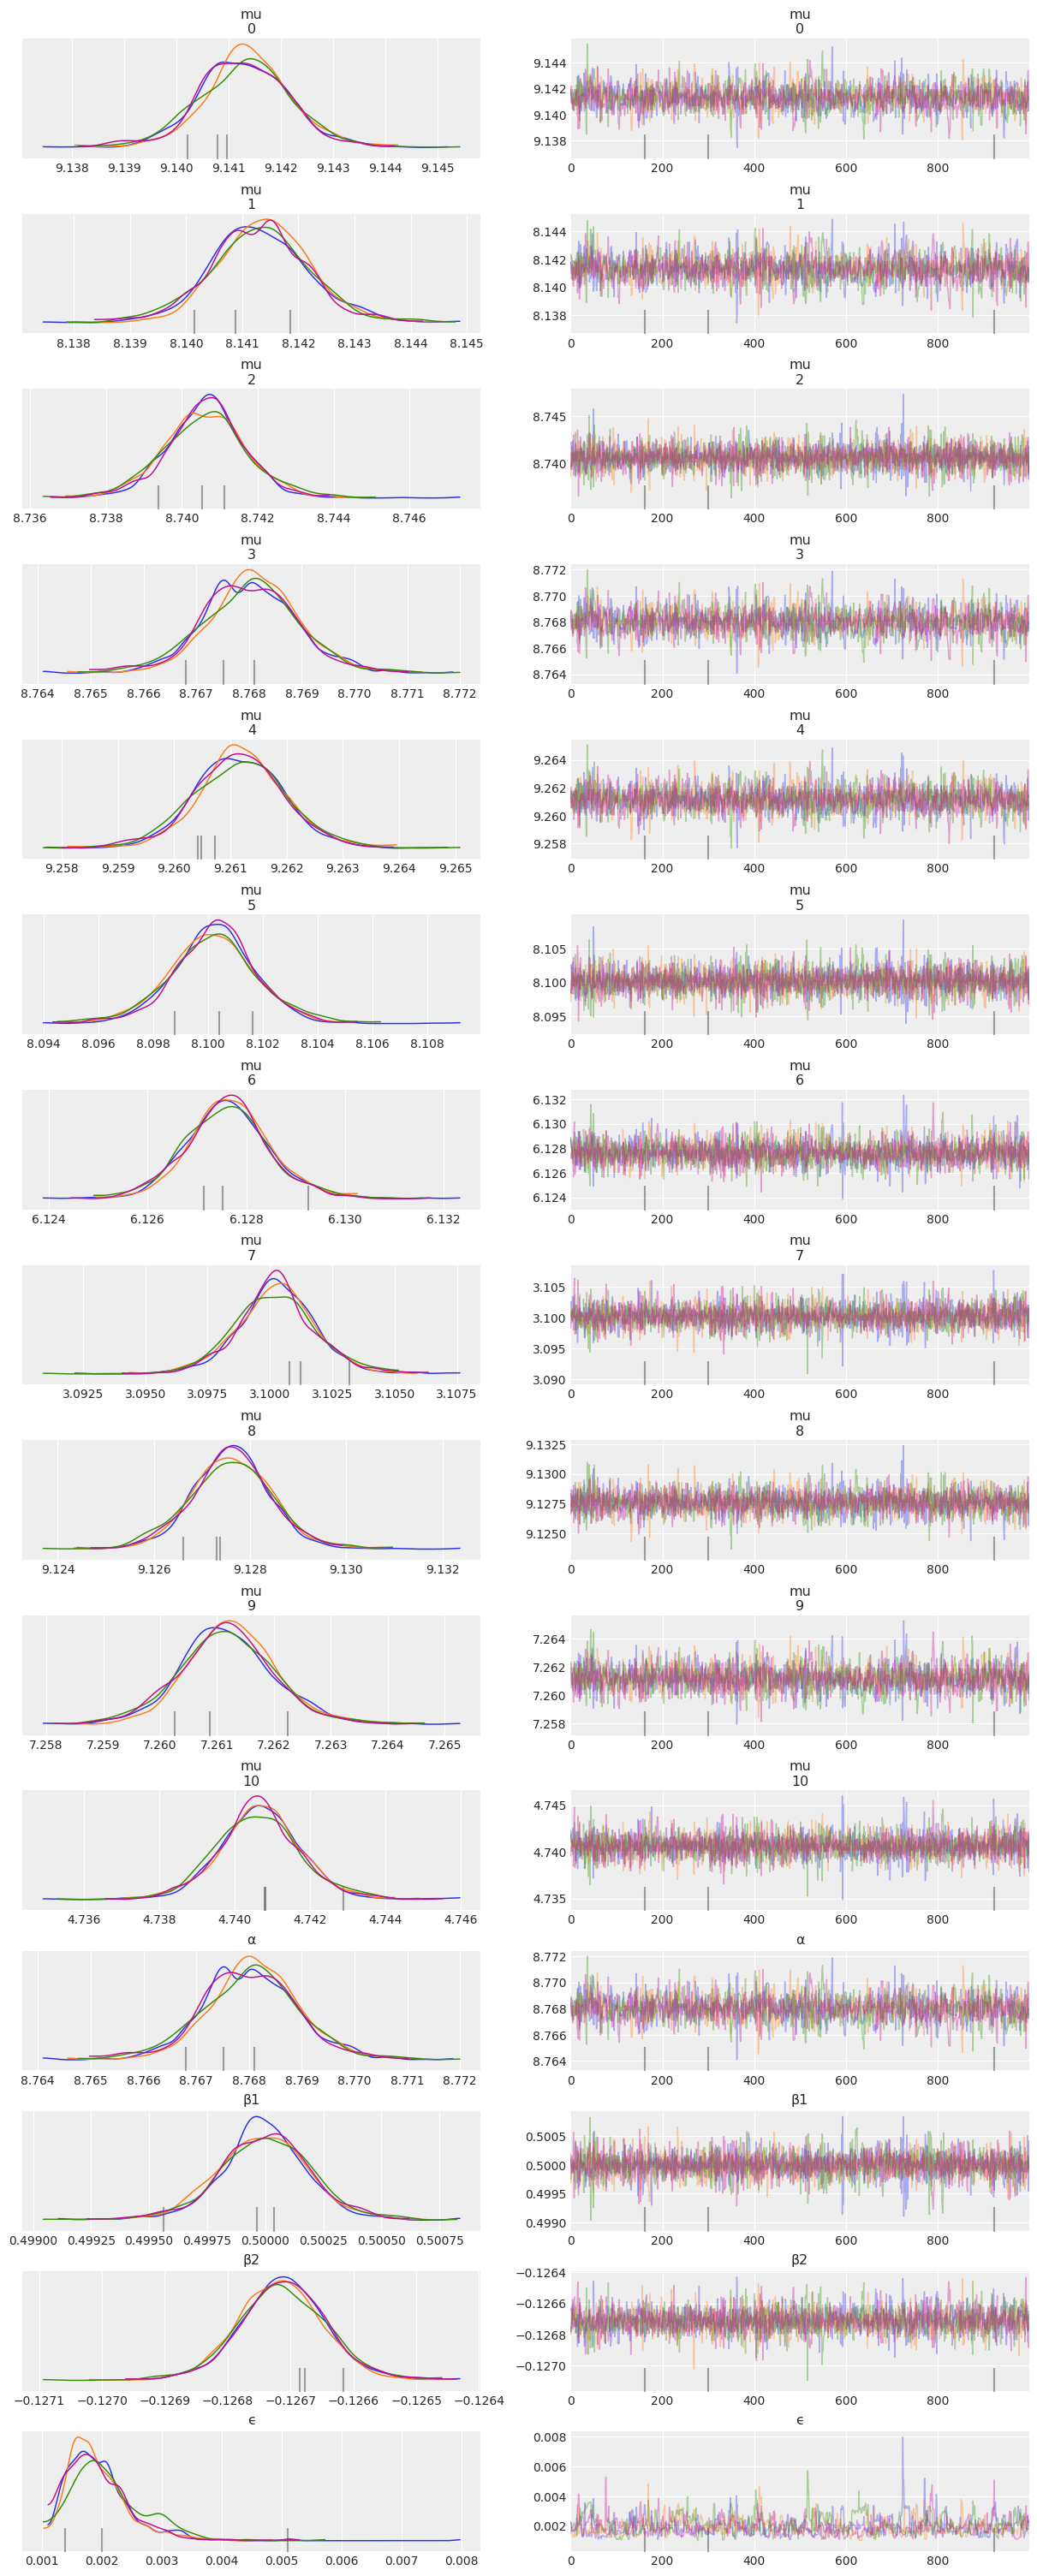

In [39]:
az.plot_trace(mcmc6, compact=False)

In [40]:
az.summary(mcmc6)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu[0]   9.141  0.001   9.140    9.143        0.0      0.0    1875.0    1538.0   
mu[1]   8.141  0.001   8.140    8.143        0.0      0.0    1795.0    1561.0   
mu[2]   8.741  0.001   8.739    8.743        0.0      0.0    4162.0    2394.0   
mu[3]   8.768  0.001   8.766    8.770        0.0      0.0    1779.0    1578.0   
mu[4]   9.261  0.001   9.260    9.263        0.0      0.0    2218.0    1754.0   
mu[5]   8.100  0.002   8.097    8.103        0.0      0.0    4036.0    2469.0   
mu[6]   6.128  0.001   6.126    6.129        0.0      0.0    2860.0    2225.0   
mu[7]   3.100  0.002   3.097    3.103        0.0      0.0    3767.0    2500.0   
mu[8]   9.128  0.001   9.126    9.129        0.0      0.0    3289.0    2529.0   
mu[9]   7.261  0.001   7.260    7.263        0.0      0.0    2014.0    1849.0   
mu[10]  4.741  0.001   4.739    4.743        0.0      0.0    3828.0    2365.0   
α       8.768  0.001   8.766    8.770        0.0      0.0    1779.0    1578.0   
β1      0.500  0.000   0.500    0.500        0.0      0.0    3816.0    1826.0   
β2     -0.127  0.000  -0.127   -0.127        0.0      0.0    2497.0    2168.0   
ϵ       0.002  0.001   0.001    0.003        0.0      0.0     359.0     735.0   

        r_hat  
mu[0]    1.00  
mu[1]    1.00  
mu[2]    1.00  
mu[3]    1.00  
mu[4]    1.00  
mu[5]    1.00  
mu[6]    1.00  
mu[7]    1.00  
mu[8]    1.00  
mu[9]    1.00  
mu[10]   1.00  
α        1.00  
β1       1.01  
β2       1.00  
ϵ        1.02

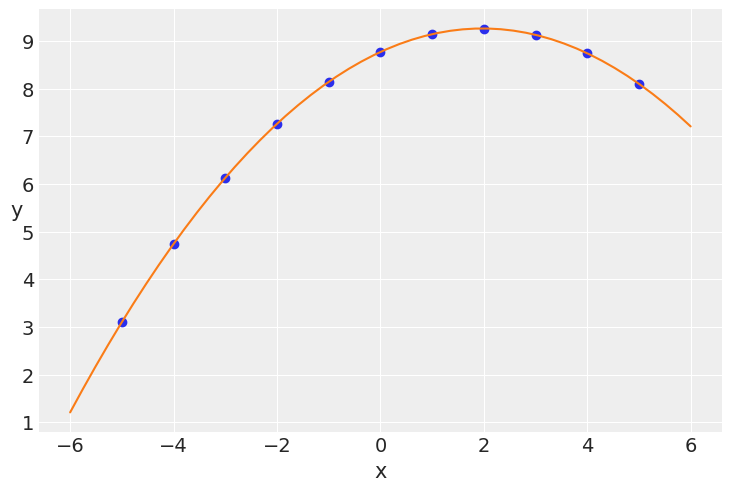

In [41]:
x_p = jnp.linspace(-6, 6)
y_p = mcmc6.get_samples()['α'].mean() + mcmc6.get_samples()['β1'].mean() * \
    x_p + mcmc6.get_samples()['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')

## Multiple Linear regression

In [42]:
N = 100
alpha_real = 2.5
beta_real = jnp.array([0.9, 1.5])
eps_real = dist.Normal(loc=0, scale=0.5).sample(random.PRNGKey(0), (N,))

X = jnp.array([dist.Normal(loc=i, scale=j).sample(random.PRNGKey(i), (N,)) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + jnp.dot(X, beta_real) + eps_real

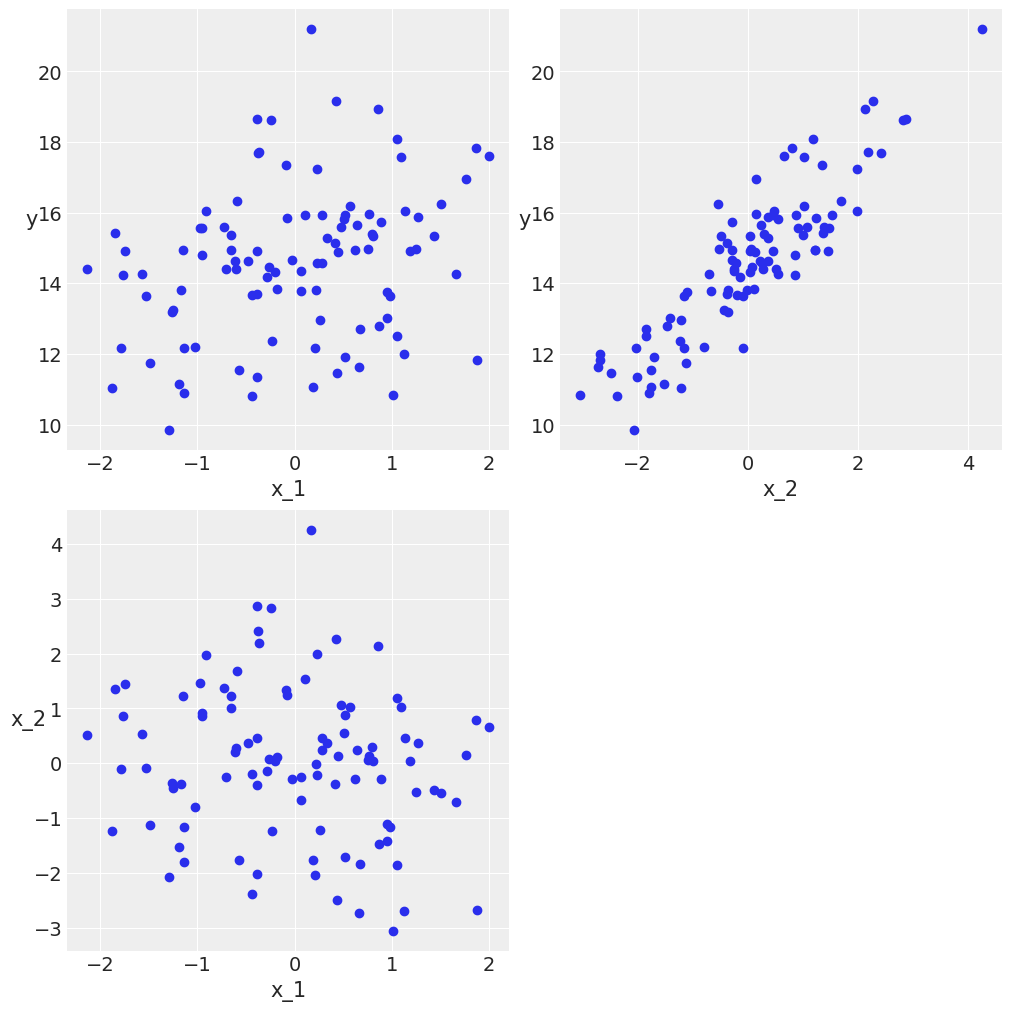

In [43]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)

In [44]:
def model(obs=None):
    α_tmp = numpyro.sample("α_tmp", dist.Normal(loc=0, scale=10))
    β = numpyro.sample("β", dist.Normal(loc=0, scale=1), sample_shape=(2,))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
                        
    μ = numpyro.deterministic('μ', α_tmp + jnp.dot(X_centered, β))
    α = numpyro.deterministic('α', α_tmp - jnp.dot(X_mean, β))
                            
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    

kernel = NUTS(model)
mcmc7 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc7.run(random.PRNGKey(seed), obs=y)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 4539.91it/s, 7 steps of size 6.91e-01. acc. prob=0.92]


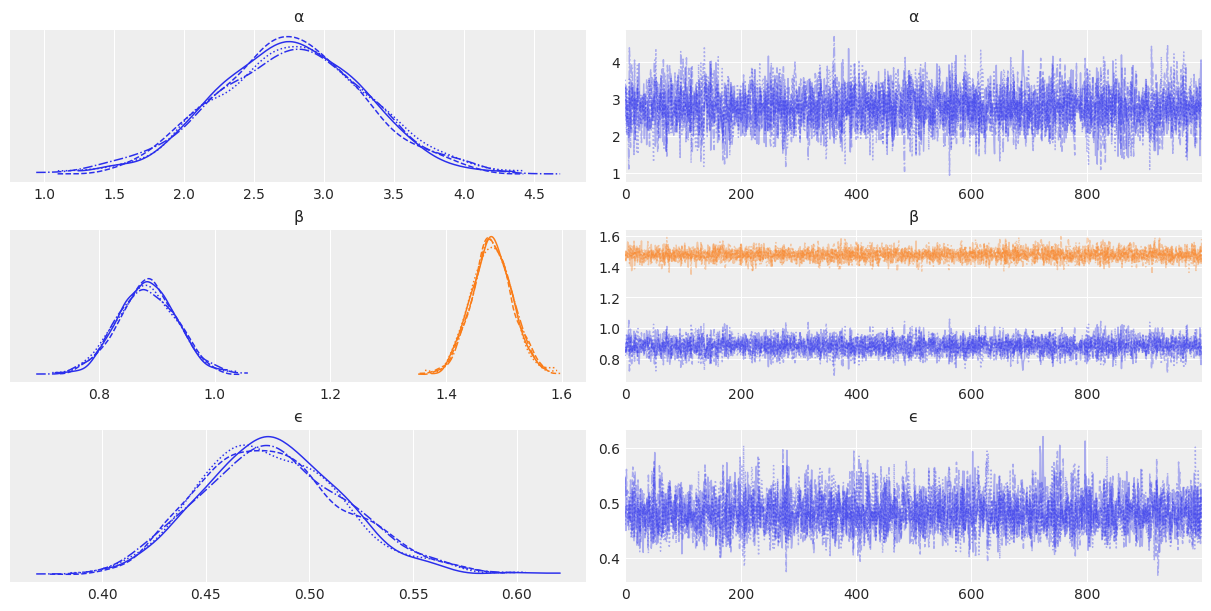

In [45]:
varnames = ['α', 'β', 'ϵ']
az.plot_trace(mcmc7, var_names=varnames);

In [46]:
az.summary(mcmc7, var_names=varnames)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α[0]  2.762  0.541   1.793    3.841      0.008    0.006    4249.0    2985.0   
β[0]  0.882  0.052   0.781    0.976      0.001    0.001    4289.0    2991.0   
β[1]  1.479  0.035   1.415    1.547      0.001    0.000    4542.0    3325.0   
ϵ     0.482  0.035   0.416    0.545      0.001    0.000    4234.0    2830.0   

      r_hat  
α[0]    1.0  
β[0]    1.0  
β[1]    1.0  
ϵ       1.0

## Confounding variables and redundant variables

In [47]:
N = 100

x_1 = dist.Normal().sample(random.PRNGKey(0), (N,))
x_2 = x_1 + numpyro.sample("x_2", dist.Normal(scale=1), rng_key=random.PRNGKey(1), sample_shape=(N,))
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + dist.Normal().sample(random.PRNGKey(2), (N,))
X = jnp.vstack((x_1, x_2)).T

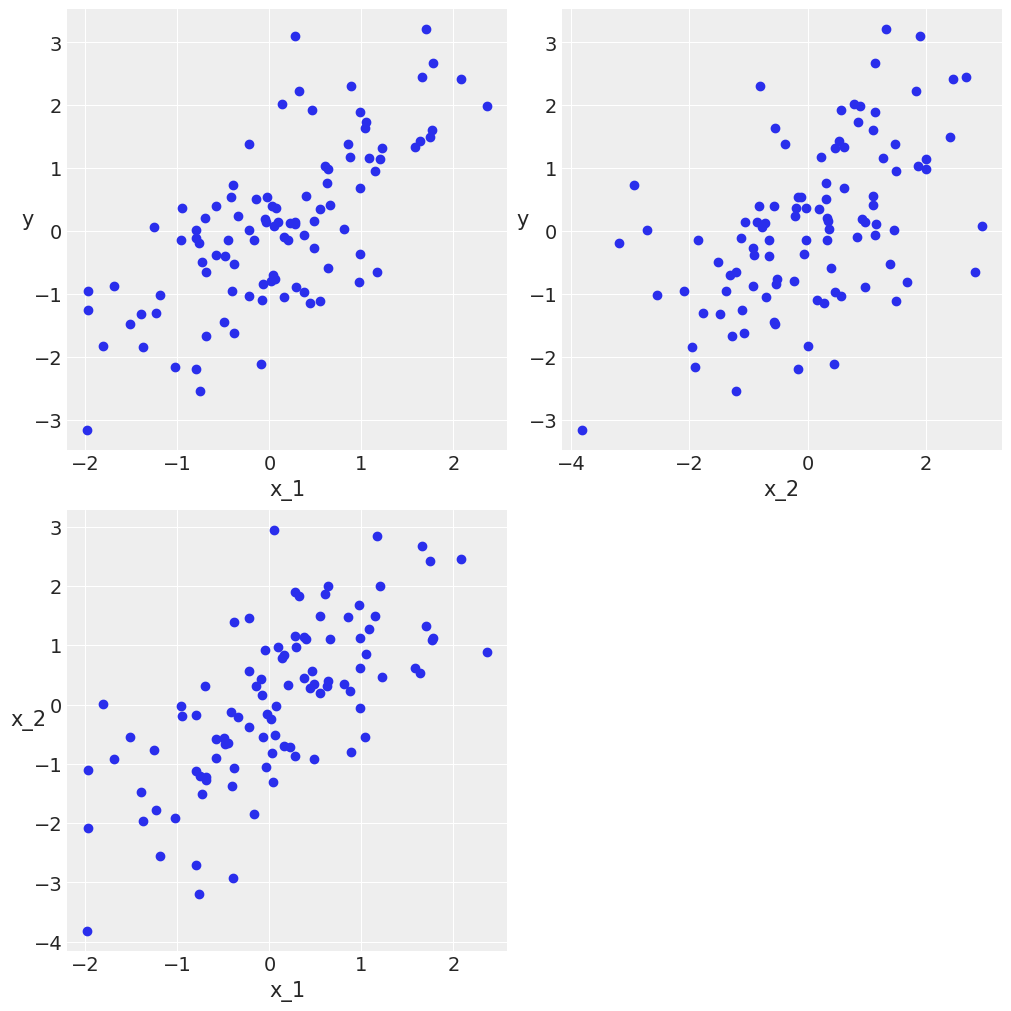

In [48]:
scatter_plot(X, y)

In [49]:
def model_x1x2(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β1 = numpyro.sample("β1", dist.Normal(loc=0, scale=10))
    β2 = numpyro.sample("β2", dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_x1x2)
mcmc_x1x2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_x1x2.run(random.PRNGKey(seed), obs=y)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 3189.88it/s, 7 steps of size 4.56e-01. acc. prob=0.94]


In [50]:
def model_x1(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β1 = numpyro.sample("β1", dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + β1 * X[:, 0]
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_x1)
mcmc_x1 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_x1.run(random.PRNGKey(seed), obs=y)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 3837.34it/s, 7 steps of size 6.53e-01. acc. prob=0.95]


In [51]:
def model_x2(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β2 = numpyro.sample("β2", dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + β2 * X[:, 1]
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_x2)
mcmc_x2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_x2.run(random.PRNGKey(seed), obs=y)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 4916.17it/s, 7 steps of size 7.58e-01. acc. prob=0.92]


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

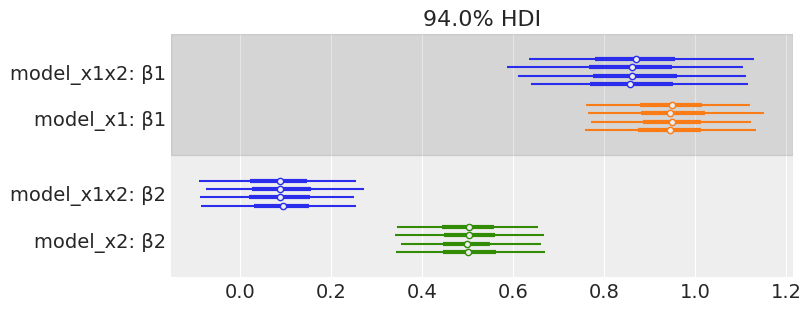

In [52]:
az.plot_forest([mcmc_x1x2, mcmc_x1, mcmc_x2],
               model_names=['model_x1x2', 'model_x1', 'model_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))

In [53]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
N = 100

x_1 = dist.Normal().sample(random.PRNGKey(0), (N,))
x_2 = x_1 + numpyro.sample("x_2", dist.Normal(scale=0.01), rng_key=random.PRNGKey(1), sample_shape=(N,))

y = x_1 + dist.Normal().sample(random.PRNGKey(2), (N,))
X = jnp.vstack((x_1, x_2)).T

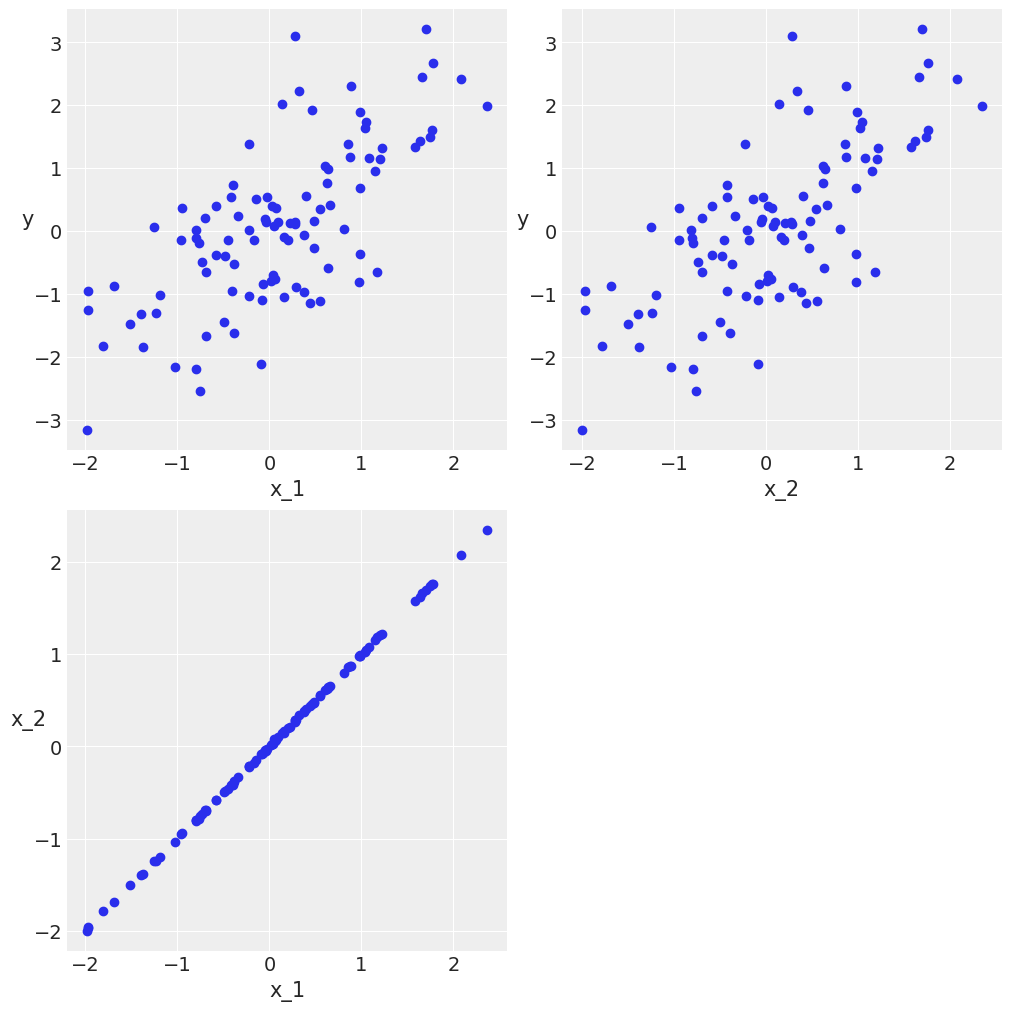

In [54]:
scatter_plot(X, y)

In [55]:
def model_red(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β = numpyro.sample("β", dist.Normal(loc=0, scale=10), sample_shape=(2,))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + jnp.dot(X, β)
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_red)
mcmc_red = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_red.run(random.PRNGKey(seed), obs=y)

sample: 100%|█████████████████████████████████████████| 2000/2000 [00:00<00:00, 2263.38it/s, 255 steps of size 1.33e-02. acc. prob=0.91]


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

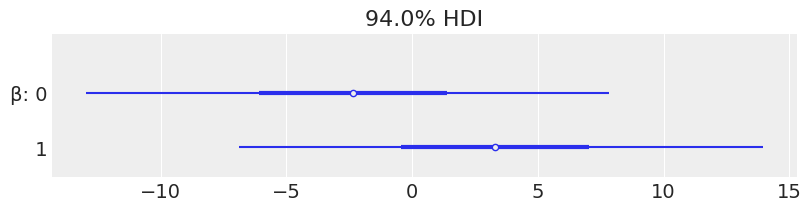

In [56]:
az.plot_forest(mcmc_red, var_names=['β'], combined=True, figsize=(8, 2))

<AxesSubplot:xlabel='β\n0', ylabel='β\n1'>

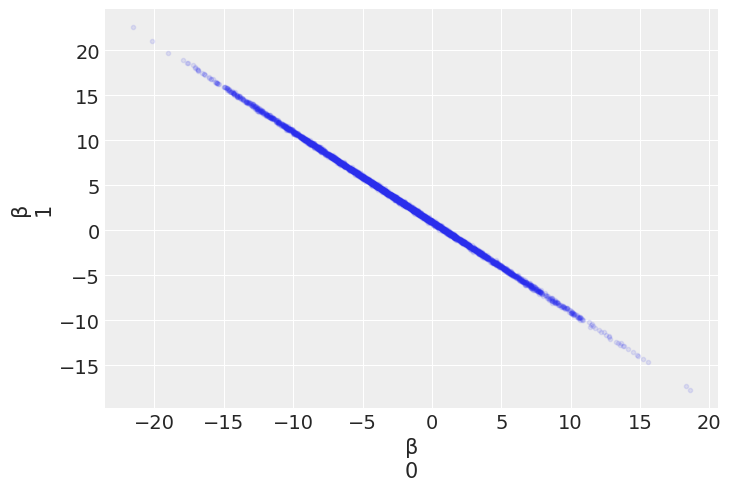

In [57]:
az.plot_pair(mcmc_red, var_names=['β'], scatter_kwargs={'alpha': 0.1})

## Masking effect variables

In [58]:
import numpy as np
np.random.seed(42)

N = 126
r = 0.8

x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)

y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

In [59]:
x_1.shape, x_2.shape, y.shape, X.shape

((126,), (126,), (126,), (126, 2))

In [60]:
# N = 126
# r = 0.8

# x_1 = dist.Normal().sample(random.PRNGKey(0), (N,))
# x_2 = dist.Normal(loc=x_1, scale=(1 - r ** 2) ** 0.5).sample(random.PRNGKey(0), (N,))

# y = dist.Normal(loc=(x_1 - x_2)).sample(random.PRNGKey(2), (N,))
# X = jnp.vstack((x_1, x_2)).T

In [61]:
# x_1.shape, x_2.shape, y.shape, X.shape

In [62]:
# TODO: Fix errors regarding shape of x_1.shape, x_2.shape, y.shape, X.shape above
# scatter_plot(X, y)

In [63]:
def model_x1x2(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β1 = numpyro.sample("β1", dist.Normal(loc=0, scale=10))
    β2 = numpyro.sample("β2", dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_x1x2)
mcmc_x1x2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_x1x2.run(random.PRNGKey(seed), obs=y)

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 4706.65it/s, 15 steps of size 3.45e-01. acc. prob=0.93]


In [64]:
def model_x1(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β1 = numpyro.sample("β1", dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + β1 * X[:, 0]
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_x1)
mcmc_x1 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_x1.run(random.PRNGKey(seed), obs=y)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 5351.96it/s, 7 steps of size 8.04e-01. acc. prob=0.91]


In [65]:
def model_x2(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=10))
    β2 = numpyro.sample("β2", dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = α + β2 * X[:, 1]
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_x2)
mcmc_x2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_x2.run(random.PRNGKey(seed), obs=y)

sample: 100%|███████████████████████████████████████████| 2000/2000 [00:00<00:00, 4068.20it/s, 7 steps of size 7.16e-01. acc. prob=0.93]


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

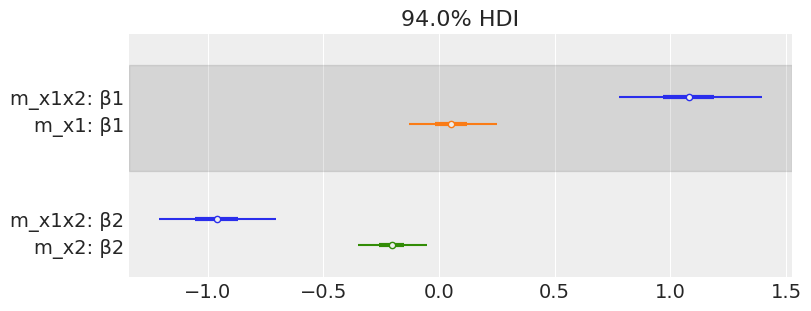

In [66]:
az.plot_forest([mcmc_x1x2, mcmc_x1, mcmc_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))

## Variable variance

<AxesSubplot:xlabel='Month', ylabel='Lenght'>

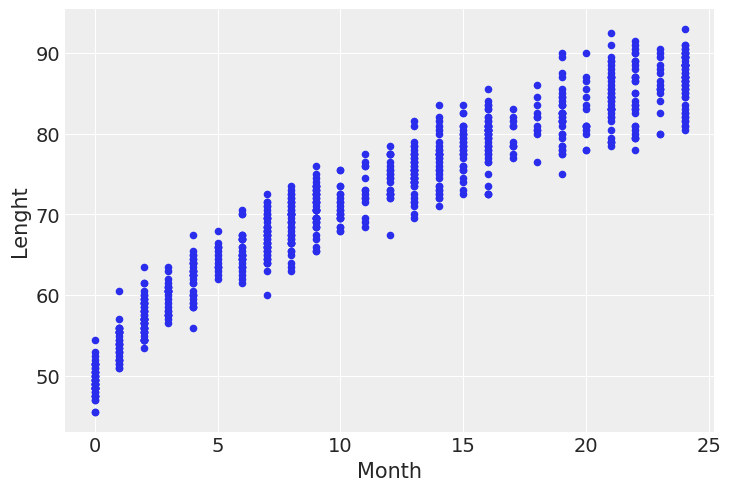

In [67]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')

In [68]:
def model_vv(obs=None):
    α = numpyro.sample("α", dist.Normal(scale=10))
    β = numpyro.sample("β", dist.Normal(scale=10))
    γ = numpyro.sample('γ', dist.HalfNormal(scale=10))
    δ = numpyro.sample('δ', dist.HalfNormal(scale=10))
    
    x_shared = (data.Month.values * 1.)  # TODO: Understand better what theano.shared() is doing
    
    μ = numpyro.deterministic('μ', α + β * x_shared**0.5)
    ϵ = numpyro.deterministic('ϵ', γ + δ * x_shared)
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
kernel = NUTS(model_vv)
mcmc_vv = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_vv.run(random.PRNGKey(seed), obs=jnp.asarray(data.Lenght))

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 4319.11it/s, 15 steps of size 3.14e-01. acc. prob=0.92]


Text(0, 0.5, 'y')

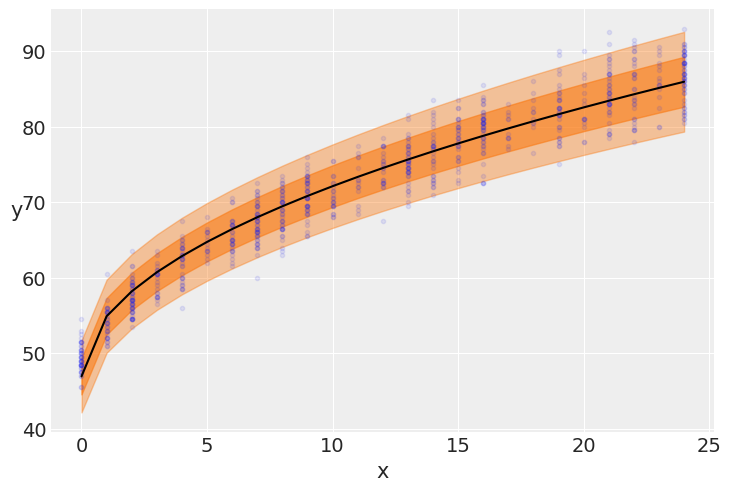

In [69]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = mcmc_vv.get_samples()['μ'].mean(0)
ϵ_m = mcmc_vv.get_samples()['ϵ'].mean(0)

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m -
                 1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m -
                 2 * ϵ_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [80]:
# x_shared.set_value([0.5]) -- Does not seem to be required
pred = Predictive(model=mcmc_vv.sampler.model, posterior_samples=mcmc_vv.get_samples(), return_sites=['y_pred'])
ppc = pred(random.PRNGKey(seed))
y_ppc = ppc['y_pred'][:, 0]

In [100]:
# https://github.com/aloctavodia/BAP/issues/69
ref = 53
# density, l, u = az._fast_kde(y_ppc) # TODO: _fast_kde deprecated. Need to investigate further 
grid, density = az.kde(y_ppc)
l, u = min(grid), max(grid)
print(l, u)
x_ = jnp.linspace(30, 60, density.shape[0])
print(density.shape)

38.56563255563378 54.932746198028326
(512,)


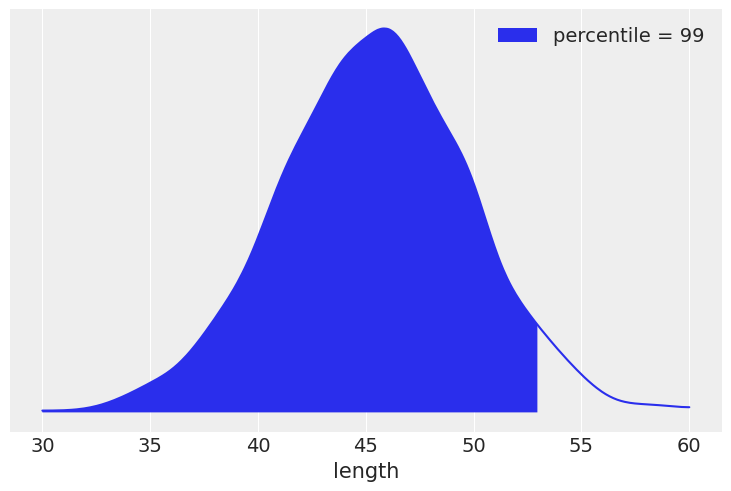

In [101]:
plt.plot(x_, density)

percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)

plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))

plt.xlabel('length')
plt.yticks([])
plt.legend()

In [73]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

def model_t2(obs=None):
    α = numpyro.sample("α", dist.Normal(loc=0, scale=100))
    β = numpyro.sample("β", dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    ν = numpyro.sample('ν', dist.Exponential(rate=1/30))
#     ν = numpyro.sample('ν', dist.Gamma(concentration=20, rate=15))
#     ν = numpyro.sample('ν', dist.Gamma(concentration=2, rate=0.1))
    
    y_pred = numpyro.sample('y_pred', dist.StudentT(df=ν, loc=α + β * x_4, scale=ϵ), obs=obs)
    
kernel = NUTS(model_t2)
mcmc_t2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='sequential')
mcmc_t2.run(random.PRNGKey(seed), obs=y_4)

sample: 100%|██████████████████████████████████████████| 2000/2000 [00:00<00:00, 4200.82it/s, 15 steps of size 1.59e-01. acc. prob=0.94]


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

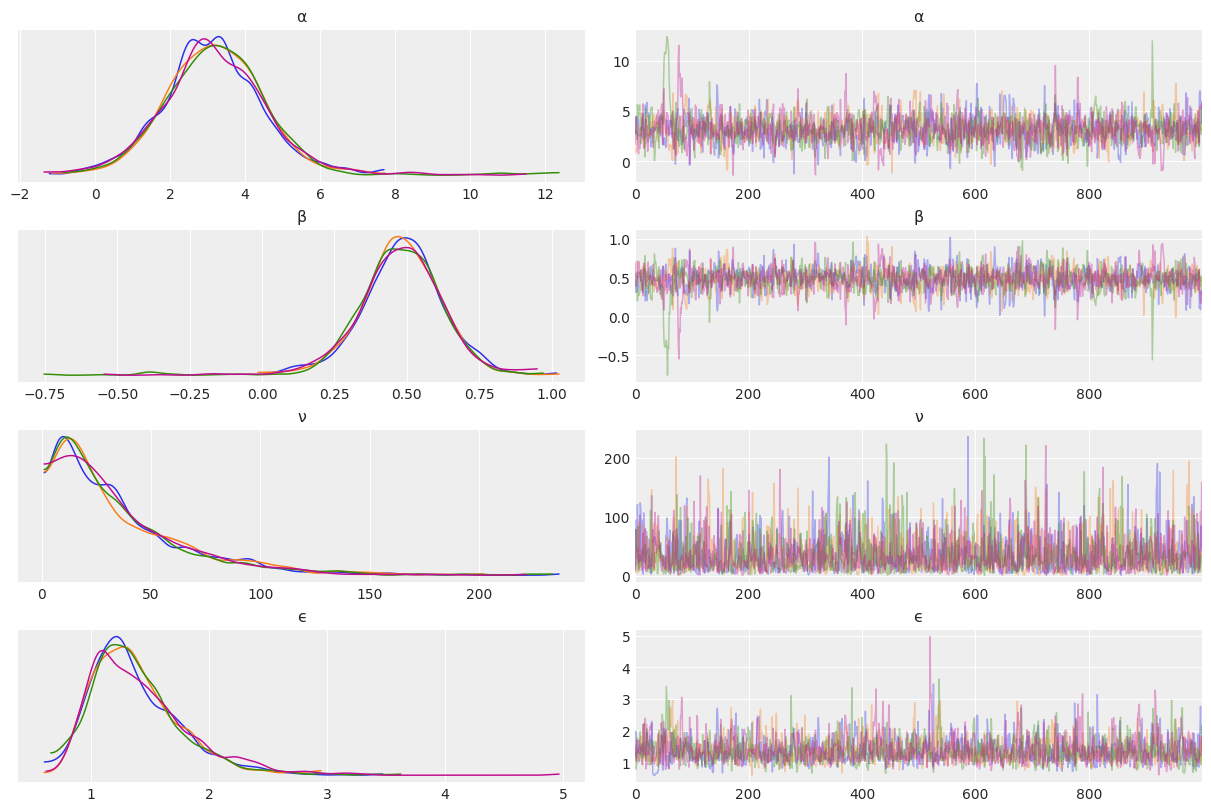

In [74]:
az.plot_trace(mcmc_t2, compact=False)

In [75]:
az.summary(mcmc_t2)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   3.190   1.399   0.681    5.748      0.042    0.035    1362.0    1362.0   
β   0.479   0.148   0.221    0.755      0.004    0.003    1403.0    1376.0   
ν  35.472  31.417   0.905   93.961      0.595    0.431    2491.0    2332.0   
ϵ   1.387   0.401   0.779    2.168      0.010    0.007    1926.0    1621.0   

   r_hat  
α    1.0  
β    1.0  
ν    1.0  
ϵ    1.0